<center>
<h4>Diplomatura Datos 2023 - FaMAF - UNC</h4>
<h2>Aplicando Machine Learning para predicción de demanda</h2>
<h2><span style="color: orange;">Introducción al Aprendizaje Supervisado en Series de Tiempo</span></h2>
</center>
</left>
<h4>Tutor: Sebastián Ormaechea</h4>
</left>

## Objetivo general

El objetivo final de la mentoría es poder predecir el próximo mes de venta de materiales en los diferentes países y zonas en donde opera la compañía proveedora. Sin embargo, los prácticos que se realizarán en esta mentoría son aplicables a compañías de cualquier vertical de negocio que quiera predecir la demanda.

<h2><span style="color: orange;">Objetivos de este notebook</span></h2>

En la presente notebook, se presentará la consigna a seguir para el tercer práctico correspondiente a las materias Introducción al Aprendizaje Automático y Aprendizaje Automático Supervisado. En la notebook se enumeran las consignas que permitirán implementar los pasos necesarios en la aplicación de diferentes métodos de aprendizaje supervisado y el desarrollo de gráficas de interpretación de resultados. Se realizan experimentos reproducibles para luego proceder a la evaluación de los métodos mas convenientes y la selección de hiperparámetros a partir del cálculo de las métricas pertinentes.</span></h2>


## Requisitos de aprobación

- Trabajo grupal: El trabajo debe ser realizado entre los integrantes del grupo asignado y solo se entrega una versión por grupo.
- Git: Deben armar un repositorio git donde vayan cargando cada uno de los prácticos (notebooks) de la mentoría.
- Informe: Este debe quedar integrado en el mismo notebook por lo que recomiendo sigan un esquema que contenga las siguientes secciones. La idea es que queden plasmados los hallazgos significativos encontrados, lo cual sirve además de base para los videos intermedio y final de la mentoria.
              - Introducción
              - Presentación del Dataset
              - Variables más relevantes o de interés
              - Respuestas a preguntas disparadoras
              - Relaciones interesantes entre variables
              - Principales conclusiones          
- Prolijidad y Claridad: Es muy importante no solo resolver las consignas técnicamente sino tambien tener la claridad en la comunicación de los hallazgos, exponer las conclusiones y tener poder de síntesis. Por ello, la presentación debe ser acompañada de los gráficos adecuados y las referencias correspondientes. Los graficos deben hablar por si mismos.
- Extensión: No hay límite de longitud en los notebooks, pero es importante que eviten salidas o outputs excesivamente extensos de cada celda del notebook, salvo que estén debidamente justificados.  

<span style="color: orange;">Fecha de Entrega del presente práctico: 11/09/2023</span>

<h2><span style="color: orange;">Introducción</span></h2>

Para cumplir con el objetivo de la mentoria necesitamos entender que nuestro dataset es una series de tiempo.
Las series temporales son conjuntos de datos secuenciales que representan observaciones recopiladas a lo largo del tiempo en intervalos regulares. Estas observaciones pueden estar vinculadas a diferentes fenómenos, como el precio de las acciones, la temperatura diaria, la producción de energía o el tráfico web. El análisis de series temporales es una disciplina fundamental en estadísticas y aprendizaje automático, ya que permite extraer patrones, identificar tendencias y realizar pronósticos para predecir eventos futuros basados en el comportamiento pasado.

Uno de los aspectos críticos en el análisis de series temporales es la dependencia temporal de los datos, es decir, cómo las observaciones pasadas pueden influir en las futuras. Para capturar esta dependencia, se utilizan los lags, que son valores pasados de la serie temporal que se añaden como características para cada punto de tiempo.

La construcción de lags implica tomar una observación en un punto de tiempo específico (t) y usar las observaciones previas a este punto para crear variables predictoras adicionales. Estos lags se incorporan como variables independientes en un modelo predictivo y permiten capturar la relación temporal entre los datos.

Por ejemplo, consideremos una serie temporal que representa la demanda diaria de productos en una tienda durante un año. Si queremos predecir la demanda del día actual (t) utilizando la demanda de los tres días anteriores, crearíamos tres lags: un lag de orden 1 (t-1), un lag de orden 2 (t-2) y un lag de orden 3 (t-3). Estos lags actuarían como características para predecir el valor de la demanda en el día actual.

La elección adecuada del número de lags y su longitud depende del problema específico y de la naturaleza de los datos. Demasiados lags pueden introducir ruido y complejidad innecesaria, mientras que muy pocos pueden no capturar toda la información relevante para hacer buenas predicciones.

Es importante tener en cuenta que al trabajar con lags, debemos asegurarnos de que los datos se encuentren en orden cronológico, por lo que el ordenamiento del dataset es crítico antes de implementar la construcción de lags. Además, es necesario considerar técnicas como el relleno de valores faltantes para evitar problemas al crear los lags.

En síntesis, los lags son una herramienta fundamental en el análisis de series temporales, ya que permiten modelar la dependencia temporal y mejorar la capacidad predictiva de los modelos. Con ellos, podemos transformar una secuencia de datos en una matriz de características adecuadamente estructurada para aplicar técnicas de aprendizaje automático y realizar pronósticos precisos en una variedad de situaciones.</

### Importacion de librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Consignas

El desarrollo de experimentos de Machine Learning implica diferentes pasos sobre los cuales tomamos decisiones sobre el dataset, los algoritmos que usamos e incluso los hiperámetros que probamos. Esto genera un sinnúmero de caminos que se pueden tomar para llegar al resultado final. A fin de no diversificar tanto los caminos y disminuir la complejidad de los experimentos, en las consignas que siguen he establecido pautas mínimas de trabajo. Por favor, aténganse a ellas y si desean explorar más experimentos, será muy bien recibido. 

### Carga de dataset curado

A los fines de realizar este práctico, utilizaremos el dataset curado en el práctico anterior. 

In [2]:
# Carga del dataset curado
df = pd.read_csv('df_curado.csv')

### Columnas a utilizar

Seleccionamos solo las columnas: 'Cantidad', 'Fecha', 'GrupoArticulos', 'codGrupoMaterial2', 'Provincia'. Como verán, solo he seleccionado "Provincia" de las variables disponibles de localización (País, Provincia, Departamento, Localidad). Además, solo he dejado algunas del resto de las variables predictoras. La idea es que trabajemos todos con las mismas columnas para no ramificar tanto los posibles experimentos, pero fundamentalmente para acelerar los tiempos de cómputo.
Dado que probablemente ya tengan codificadas muchas columnas, seleccionen solo las codificaciones que correspondan a esta lista.

In [3]:
# Defino las variables de interés para trabajar en este TP 
df = df[['Cantidad', 'Fecha', 
        'GrupoArticulos', 'codGrupoMaterial2', 
        'Provincia']]

Es posible que en el práctico anterior hayan tomado alguna decisión en lo que respecta a las variables categóricas. Algunas opciones pueden haber sido:

* One-Hot Encoding: Esta técnica crea columnas binarias para cada categoría única en las variables categóricas que se consideren. Por ejemplo, en la variable "Departamento", cada departamento se representará como una columna separada con valores binarios (0 o 1) para indicar su presencia o ausencia en cada registro de datos. Esta técnica es útil cuando el número de categorías únicas no es muy grande y tienes suficiente capacidad computacional para manejar el aumento en el tamaño del DataFrame.

* Label Encoding: En lugar de crear nuevas columnas binarias, el Label Encoding asigna un número entero a cada categoría única en la variable a manejar. Por ejemplo, si tienes 1000 localidades, cada localidad se representaría con un número del 1 al 1000. Es una opción más compacta que One-Hot Encoding, pero deben tener en cuenta que el orden de los números asignados no implica ninguna relación de orden real entre las localidades. Aplicar Label encoding puede introducir sesgo en el modelo, ya que el modelo puede interpretar implícitamente una relación de orden entre ellas, lo que podría introducir sesgos en las predicciones. Por ejemplo, el modelo podría interpretar erróneamente que las localidades con números más altos tienen valores más altos del target, lo que afectaría negativamente el rendimiento del modelo.

### Codificación de categóricas

En el caso de que aún no hayan codificado las categóricas, implementenlo aquí **sin incluir "Provincia"**

In [4]:
# Codificación de categóricas sin inluir Provincia


### Contrucción de lags

In [5]:
# Paso 1: Ordenar el dataset temporalmente
df['Fecha'] =   # Asegurarse de que la columna de fechas esté en formato de fecha
df =   # Ordenar los datos cronológicamente por la columna 'Provincia' y 'Fecha'

In [6]:
# Paso 2: Definir la Fecha como index del dataframe.


In [7]:
# Paso 3: Crear las columnas de lags
# Definimos la función que calcula n valores anteriores de una columna dada 
def shift_df(df, n_lags, shifted_column, groupCol):
    
    for i in range(1, n_lags+1):
        df['t-{}'.format(i)] = df.groupby(groupCol,as_index=False)[shifted_column].shift(i)
    return df

# Aplicamos la función lo cual calcula n periodos para atras de la variable objetivo agrupada por Provincia


### Codificación de "Provincia"

Finalmente, nos falta ver qué hacer con la variable Provincia. Aplicaremos por separado dos opciones de codificación. De esta manera, obtendremos dos datasets con diferente tipo de curación. La idea de esto es que luego pensemos en las implicancias de cada opción (dimensionalidad, costo computacional, tiempo de ejecución, etc.), considerando además las diferencias en las métricas.

In [8]:
# Dataset con One hot encoding
column_to_encode = ['Provincia']

df_hot =               # Aplicamos codificación one hot encoding sobre Provincia

print(len(df_hot.columns))

39


In [9]:
# Dataset con Label encoding
label_encoder = LabelEncoder()

df_label =
print(len(df_label.columns))

14


### División en Train/Test

Finalmente, estámos en condiciones de **dividir el dataset en Train y Test**. Teniendo en cuenta que estamos utilizando series temporales la división de train y test no puede ser aleatoria sino que debe respetar una linea de tiempo. Para este TP, utilizaremos el año 2021 para test y el resto de los años para train.

In [10]:
# División del dataset en Train y Test de df_hot
df_train_hot = df_hot[df_hot.index < '2021-01-01 00:00:00']
df_test_hot =  df_hot[df_hot.index >= '2021-01-01 00:00:00']

x_train_h = 
x_test_h = 

y_train_h = 
y_test_h = 

In [11]:
# División del dataset en Train y Test de df_label
df_train_label = df_label[df_label.index < '2021-01-01 00:00:00']
df_test_label =  df_label[df_label.index >= '2021-01-01 00:00:00']

x_train_l = 
x_test_l = 

y_train_l = 
y_test_l = 

### Modelado y evaluación de métricas

Con el fin de experimentar los distintos algoritmos de ML para predecir la demanda se presentan algunos modelos que podrían utilizar e identificar cual es el mas conveniente en función a las métricas. <span style="color: orange;">Prueben al menos 3 algoritmos sobre ambos datasets y calculen las métricas MSE, MAE y R Square sobre el conjunto de test. Comparar las métricas obtenidas en cada modelo y obtener conclusiones.</span>
Cabe aclarar que si encuentran cualquier otro algoritmo que consideren apropiado y deseen aplicar, pueden hacerlo con total libertad.

- Linear Support Vector Regression ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR))
- Stochastic Gradient Descent ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor))
- KNeighborsRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor))
- Prediction Voting Regressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor))
- XGBRegressor  ([Doc](https://xgboost.readthedocs.io/en/latest/python/python_api.html)) 
- Random Forest Regressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)) 
- LGBMRegressor ([Doc](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)) 

In [12]:
# Evalúo df_hot con XGBRegressor
model_h = XGBRegressor()
model_h.fit(x_train_h, y_train_h)
y_pred_h = model_h.predict(x_test_h)

MAE_h = mean_absolute_error(y_test_h, y_pred_h)
MSE_h = mean_squared_error(y_test_h, y_pred_h)
r2_h = r2_score(y_test_h, y_pred_h)
print(MAE_h, MSE_h, r2_h)

26.74244703809967 9820.868300029684 0.07296857188429051


In [13]:
# Evalúo df_label con XGBRegressor
model_l = XGBRegressor()
model_l.fit(x_train_l, y_train_l)
y_pred_l = model_l.predict(x_test_l)

MAE_l = mean_absolute_error(y_test_l, y_pred_l)
MSE_l = mean_squared_error(y_test_l, y_pred_l)
r2_l = r2_score(y_test_l, y_pred_l)
print(MAE_l, MSE_l, r2_l)

26.92636895517434 9663.704606762663 0.08780388772055159


### Grid Search

GridSearch, o búsqueda en cuadrícula, es una técnica comúnmente utilizada en aprendizaje automático para encontrar los mejores hiperparámetros para un modelo. Los hiperparámetros son valores que no se aprenden directamente durante el proceso de entrenamiento del modelo, sino que se definen antes de iniciar el proceso de entrenamiento. Estos hiperparámetros afectan la estructura y el rendimiento del modelo.

El proceso de GridSearch implica la definición de un conjunto de posibles valores para cada hiperparámetro que se desee ajustar. Luego, se realiza una búsqueda exhaustiva (de ahí el término "en cuadrícula") de todas las combinaciones posibles de los valores de los hiperparámetros para evaluar el rendimiento del modelo con cada combinación. 

El objetivo del GridSearch es encontrar la combinación de hiperparámetros que produzca el mejor rendimiento del modelo según una métrica de evaluación específica.

<span style="color: orange;">Utilicen el método *Grid Search*, para el algoritmo que arrojó el mejor MAE. Para ello elijan al menos 2 hiperparámetros y 3 valores en cada uno. Tengan en cuenta que a medida que probamos más hiperparámetros y más valores para cada uno, se incrementa el tiempo de procesamiento.</span> 

### Feature importance

Feature Importance, o importancia de características, es un concepto importante en el aprendizaje automático y se refiere a la evaluación de la contribución relativa de cada característica o variable predictora en un modelo de aprendizaje automático para realizar predicciones. Es decir, determina qué tan importante es cada característica para explicar o predecir la variable objetivo.

La importancia de características puede ser valiosa en varias situaciones:

Selección de características: Permite identificar qué características son las más relevantes para un modelo, lo que puede ayudar a reducir la dimensionalidad y mejorar la eficiencia del modelo.

Entendimiento del modelo: Proporciona información sobre cómo el modelo está tomando decisiones y qué características son más influyentes en esas decisiones, lo que puede ser útil para interpretar el modelo.

Detectar características irrelevantes: Si se encuentran características con importancia cercana a cero, es probable que sean irrelevantes para el modelo y puedan eliminarse para mejorar la simplicidad y la eficacia del modelo.

<span style="color: orange;">Seleccionen el mejor modelo de lo obtenido en GridSearch y determinen la importancia relativa de cada variable predictora.</span>

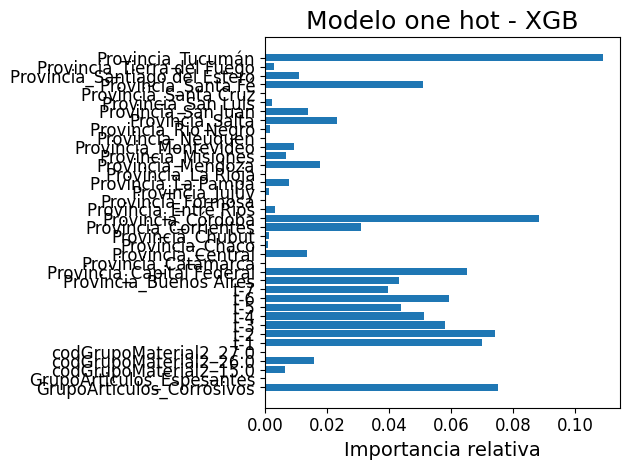

In [14]:
# Código para visualizar la importancia relativa de cada feature


### Plots

Finalmente, vamos a realizar **dos tipos de gráficas** importantes para el proceso de Aprendizaje Supervisado:

- **Tipo Predichos vs observados**: Cuando entrenamos un modelo en un conjunto de datos, utilizamos parte de los datos para entrenar el modelo y la otra parte para evaluarlo. Después de entrenar el modelo, lo ponemos a prueba en los datos de evaluación para ver cómo se desempeña en datos no vistos. Mediante esta gráfica podemos comparar los valores predichos por el modelo con los valores observados en el conjunto de evaluación.

- **Tipo Serie temporal original versus predicha**: Esta gráfica compara los valores reales observados en la serie temporal con los valores que el modelo ha predicho para el mismo período de tiempo. La idea además es ver el comportamiento del target en el período usado para entrenamiento y ver cómo el modelo pronostica las ventas en los meses siguientes.

<span style="color: orange;">Elijan solo un dataset y realicen solo una gráfica de cada tipo e interpreten los resultados brevemente. Para el gráfico de serie temporal solo utilicen la provincia de Buenos Aires, y no olviden que para cada fecha pueden tener mas de una venta, por lo que deben sumar Cantidades</span>

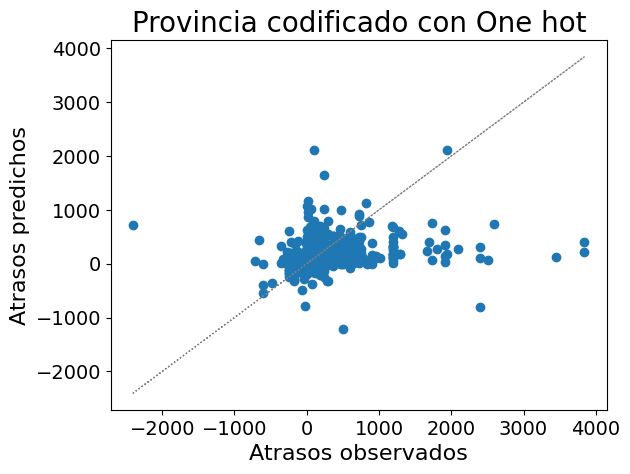

In [16]:
# Gráfica Tipo Predichos vs Observados


In [18]:
# Gráfica de Serie temporal original versus predicha
# Paso 1. Filtrar los datos correspondientes a la categoría 'Buenos Aires'


In [19]:
# Paso 2. Crear un dataframe solo con los datos de test de Buenos Aires


In [ ]:
# Paso 3. Crear una columna de predichos para los datos de test de Buenos Aires


In [21]:
# Paso 4. Agrupar valores para cada index y sumarlos


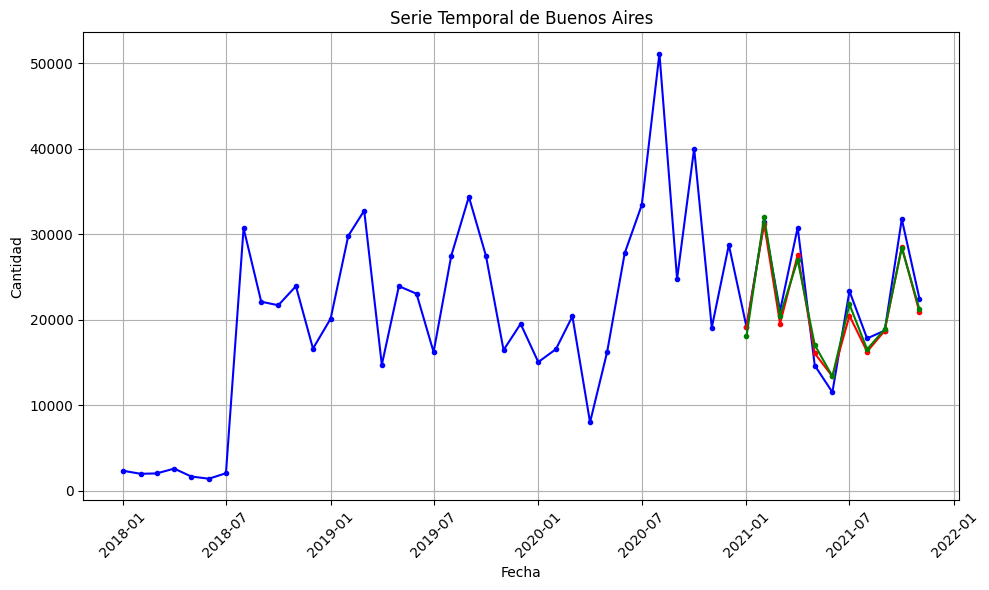

In [22]:
# Paso 5. Crear el gráfico de la serie temporal


# Opcional

### PCA 
En el TP anterior, implementaron el uso de Análisis de Componentes Principales para reducción de dimensionalidad. La consigan en este puntos es utilizar los componentes principales obtenidos para el entrenamiento y testeo de un modelo bajo un algoritmo elegido por ustedes.
Finalmente, deberán interpretar los resultados obtenidos

### Log Transformation
Una herramienta interesante en algunos problemas de Machine learning es la transformación logarítmica de las variables predictoras o del target. Su aplicación puede mejorar las métricas de performance de modelos dependiendo de las características del dataset.
La consigna aquí es probar la transformación logarítmica del target, evaluar las métricas e interpretar brevemente los resultados.